In [1]:
import os, sys
import numpy as np
import uproot
import awkward as ak
import pandas as pd
from time import time

import pickle
import json

from scipy import stats
from scipy.optimize import minimize
from scipy.optimize import curve_fit

import warnings
warnings.filterwarnings("ignore")

In [38]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In order to use the scripts in utils, add the path to your working directory to PYTHONPATH.

In [10]:
path_to_repo = '/'.join(os.getcwd().split('/')[:-1])
sys.path.append(path_to_repo)

from src.utils.pltutils import plt
plt.style.use(path_to_repo+'/src/utils/simple.mplstyle')

from src.utils.fit_utils import GausPDF, Pol1PDF, fit_gaussian_res

In [17]:
#prediction_file = '<path_to_prediction_file>'
prediction_file = '/home/rusack/shared/pickles/hgcal_electron/flat_0001/dnn_output.pickle'
target_file = '/home/rusack/shared/pickles/hgcal_electron/flat_0001/target.pickle'

In [18]:
with open(prediction_file, 'rb') as file_:
    predictions = pickle.load(file_)
with open(target_file, 'rb') as file_:
    targets = pickle.load(file_)

In [19]:
rechit_energy_file = '/home/rusack/shared/pickles/hgcal_electron/flat_0001/rechit_energy.pickle'
with open(rechit_energy_file, 'rb') as file_:
    energies = pickle.load(file_)

In [20]:
fit_parameters_ml_train = {}
fit_parameters_sum = {}

<Figure size 432x288 with 0 Axes>

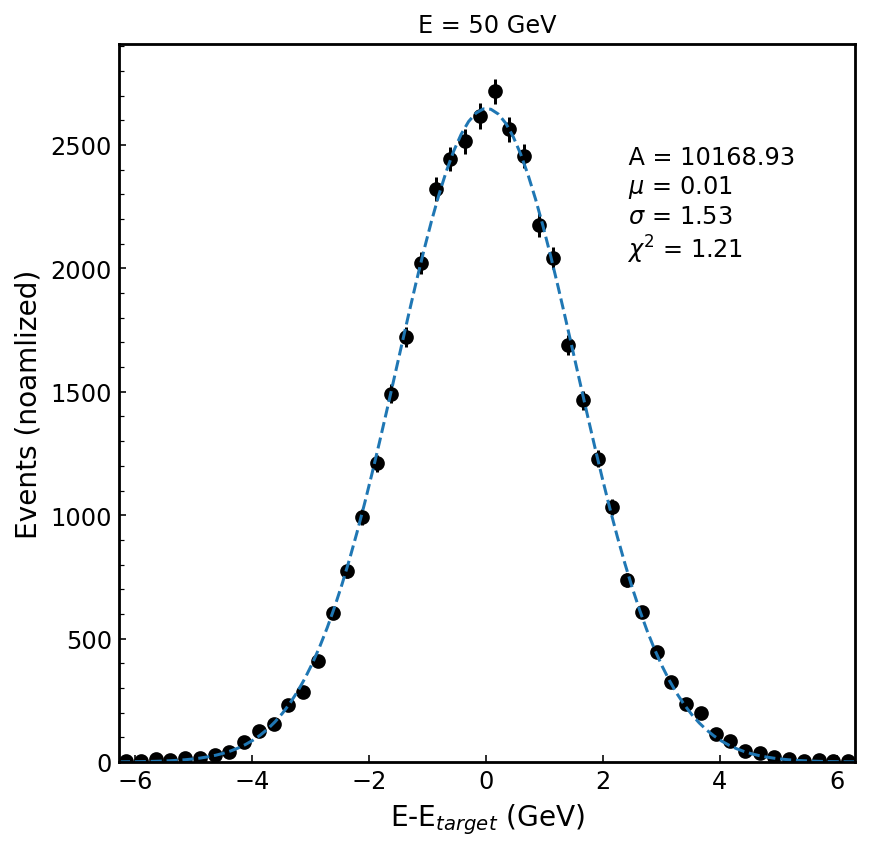

In [45]:
plt.clf()
fig, axarray = plt.subplots(1, 1)
fig.set_figheight(6.6)
fig.set_figwidth(6.6)

e = 50
e_min = 40
e_max = 60
mask = np.logical_and(targets>e_min, targets<e_max)
T = np.array(targets)[mask]
P = np.array(predictions)[mask]
#S = np.array(ak.sum(energies, axis=1)[mask]*0.01)
fit_gaussian_res(P-T, axarray, 'mc', e)
plt.savefig('dnn_resolution.png', dpi=300)

<Figure size 432x288 with 0 Axes>

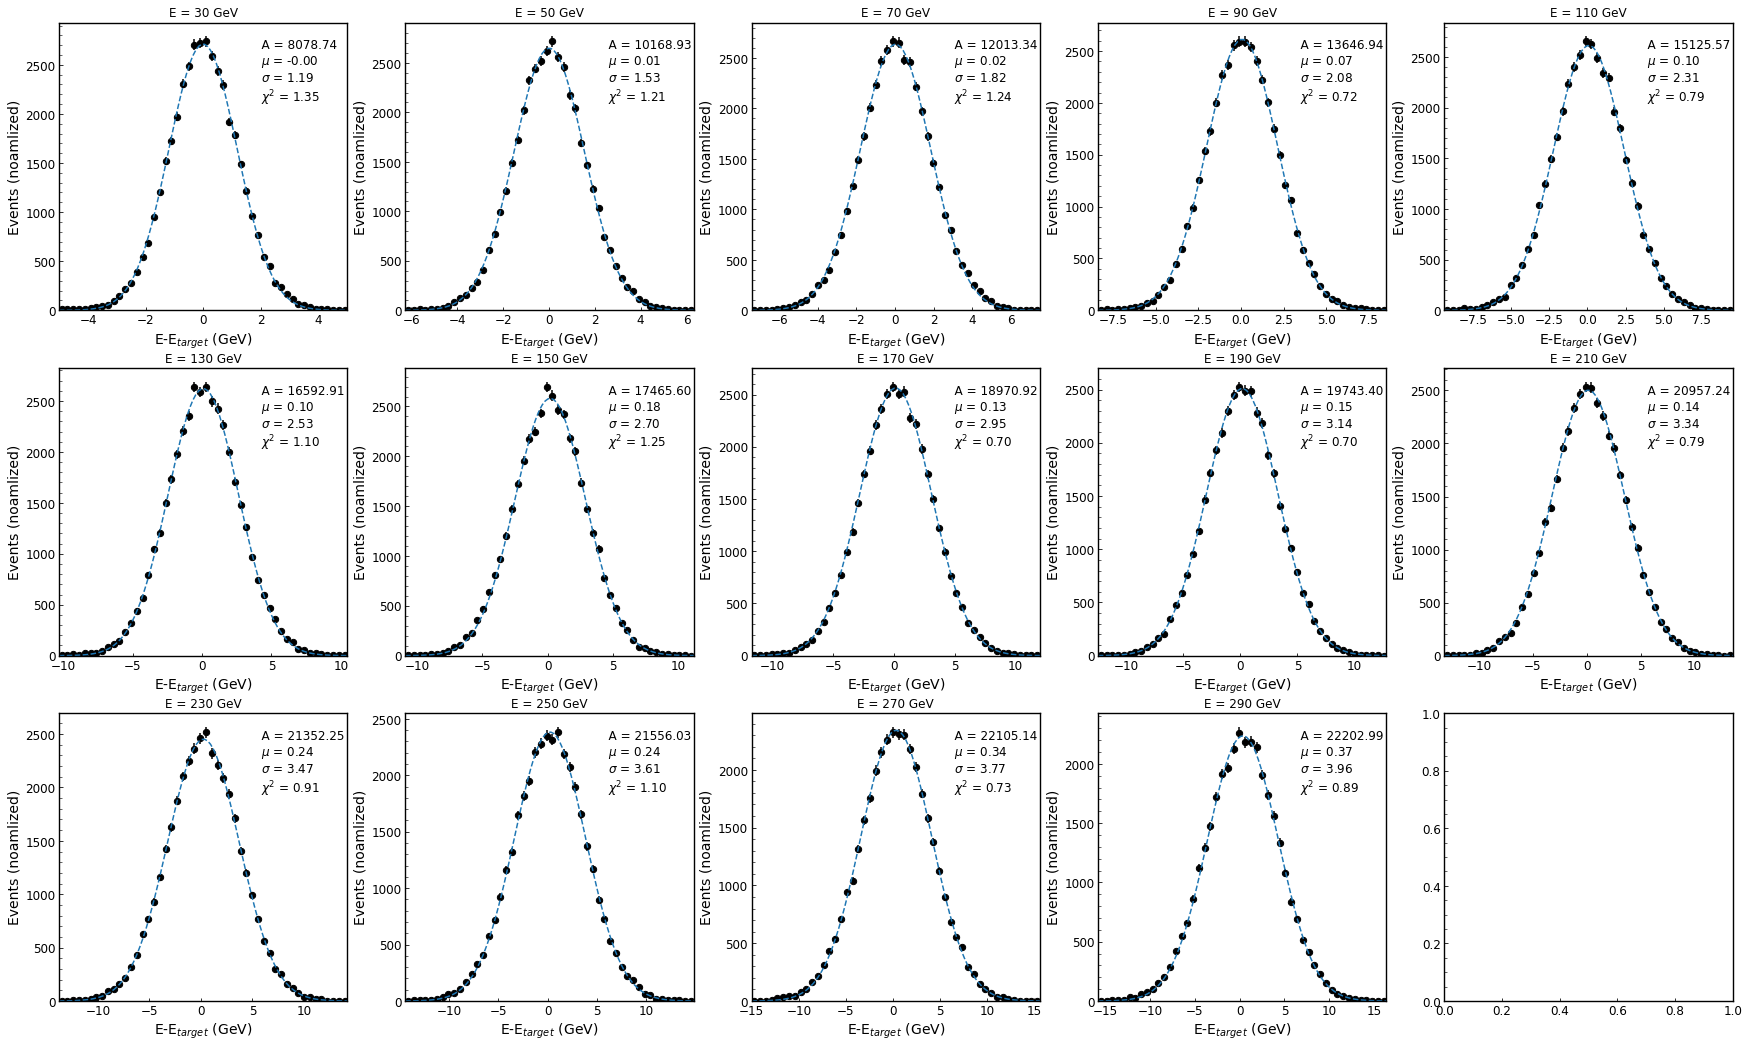

In [22]:
plt.clf()
fig, axarray = plt.subplots(3, 5)
fig.set_figheight(18)
fig.set_figwidth(30)

sigma_e = []
mean_e = []
target_e = []

for i in range(14):
    irow = int(i/5)
    jcol = int(i%5)
    e = (2*i+3)*10
    e_min = (i+1)*20
    e_max = (i+2)*20
    mask = np.logical_and(targets>e_min, targets<e_max)
    T = np.array(targets)[mask]
    P = np.array(predictions)[mask]
    fit_parameters_ml_train[e] = fit_gaussian_res(P-T, axarray[irow, jcol], 'mc', e)
plt.show()

<Figure size 432x288 with 0 Axes>

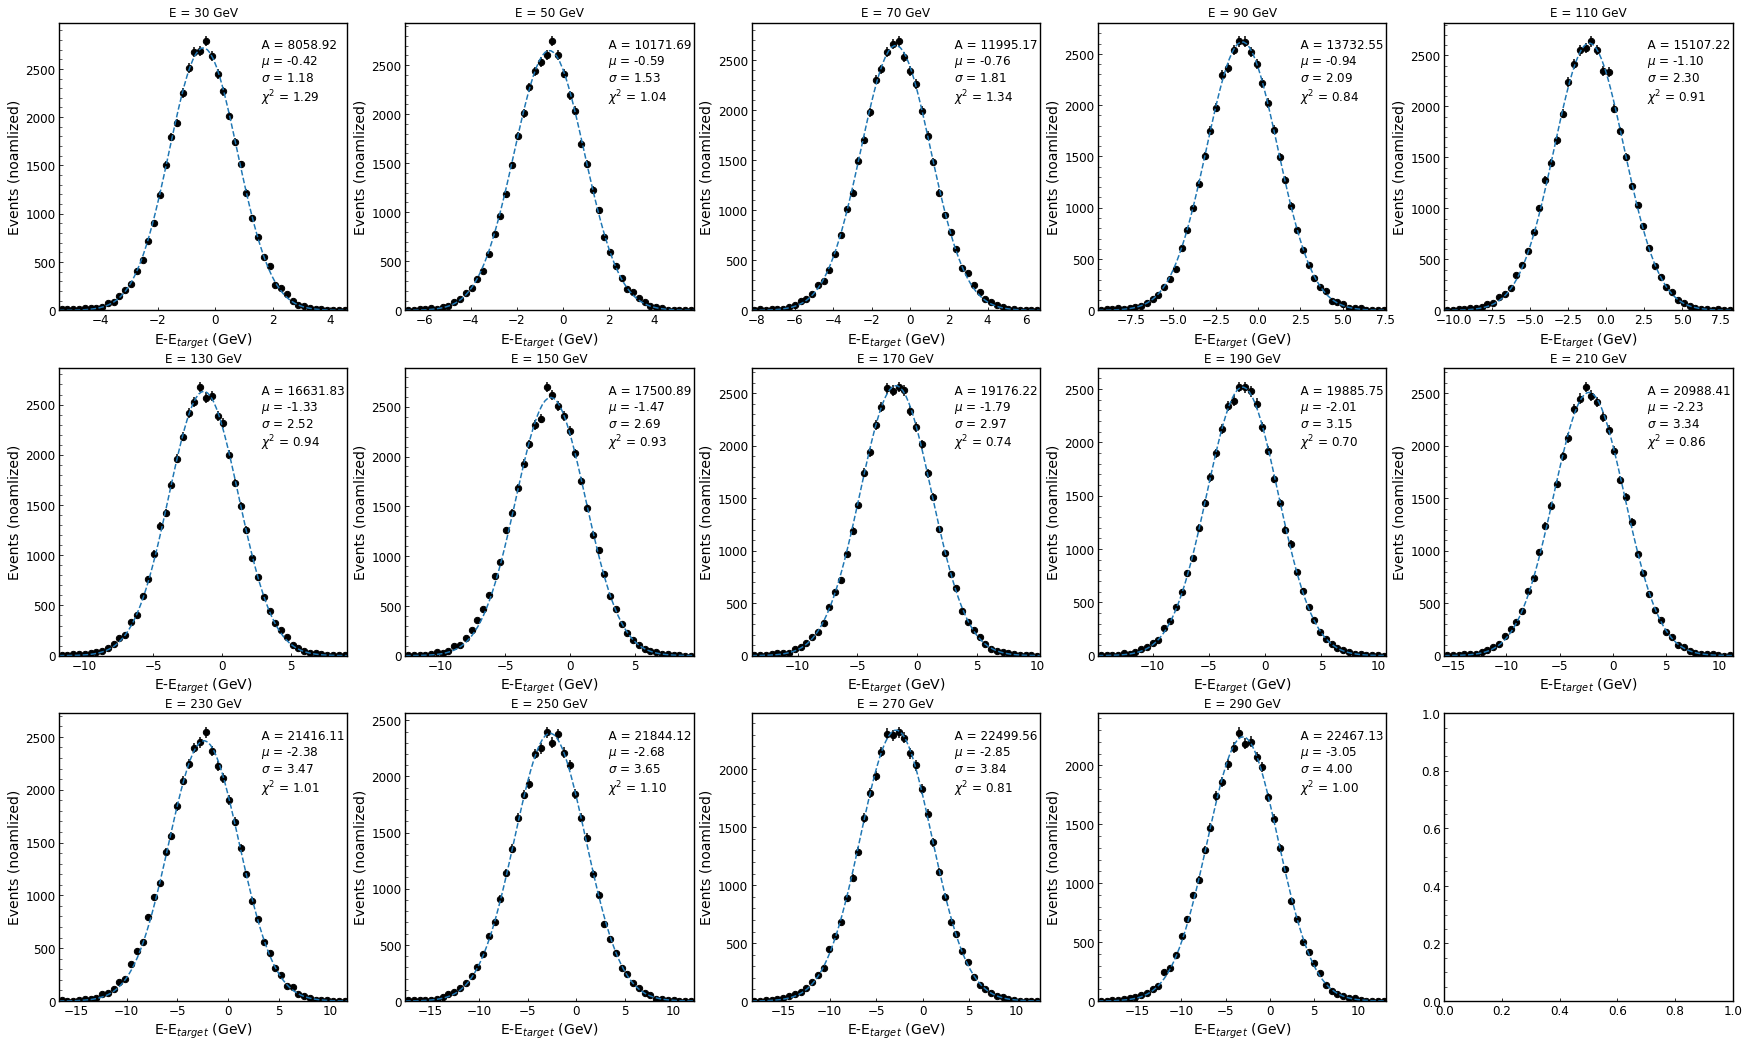

In [24]:
plt.clf()
fig, axarray = plt.subplots(3, 5)
fig.set_figheight(18)
fig.set_figwidth(30)

sigma_e = []
mean_e = []
target_e = []

for i in range(14):
    irow = int(i/5)
    jcol = int(i%5)
    e = (2*i+3)*10
    e_min = (i+1)*20
    e_max = (i+2)*20
    mask = np.logical_and(targets>e_min, targets<e_max)
    T = np.array(targets)[mask]
    P = np.array(ak.sum(energies, axis=1)[mask]*0.01)
    fit_parameters_sum[e] = fit_gaussian_res(P-T, axarray[irow, jcol], 'mc', e)
plt.show()

<Figure size 432x288 with 0 Axes>

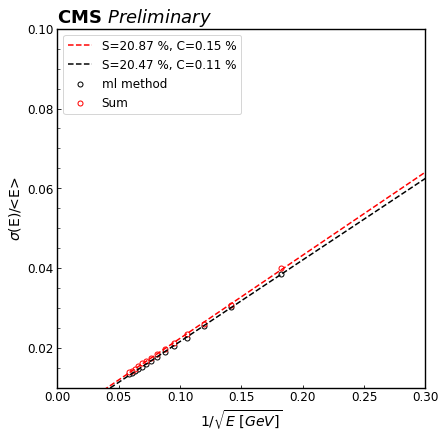

In [34]:
plt.clf()
plt.figure(figsize=(6.6,6.6))

mean_e = 1/np.sqrt(np.array([ e for e in fit_parameters_ml_train]))
res_e = np.array([ fit_parameters_ml_train[e][2]/e for e in fit_parameters_ml_train])
plt.scatter(mean_e, res_e,
            marker='.', s=100, edgecolor='black', label='ml method',
            facecolor='w')
res_results_ml = curve_fit(Pol1PDF, xdata=mean_e, ydata=res_e,
         bounds = ((0,0), (1e3,1e3)), p0=(0.2, 0.02))

res_e = np.array([fit_parameters_sum[e][2]/e for e in fit_parameters_sum])
plt.scatter(mean_e, res_e,
            marker='.', s=100, edgecolor='red', label='Sum',
            facecolor='w')
res_results_sum = curve_fit(Pol1PDF, xdata=mean_e, ydata=res_e,
         bounds = ((0,0), (1e3,1e3)), p0=(0.2, 0.02))


xarray = np.linspace(0.0, 0.55, 64)
yarray_data_sum =  res_results_sum[0][0]*xarray+res_results_sum[0][1]
yarray_data_ml = res_results_ml[0][0]*xarray+res_results_ml[0][1]

plt.plot(xarray, yarray_data_sum, c='red', linestyle='--',
         label='S={:0.2f} %, C={:0.2f} %'.format(res_results_sum[0][0]*100, res_results_sum[0][1]*100))
plt.plot(xarray, yarray_data_ml, c='black', linestyle='--',
         label='S={:0.2f} %, C={:0.2f} %'.format(res_results_ml[0][0]*100, res_results_ml[0][1]*100))

cms = plt.text(x=0.0, y=0.1, s="CMS $\it{Preliminary}$",
    fontsize=18, fontweight='bold',
    fontfamily='sans-serif',
    horizontalalignment='left', 
    verticalalignment='bottom')

slope_text= plt.text(x=0.06, y=0.035, s='')

plt.ylim(0.01, 0.1)
plt.xlim(0.0, 0.30)
plt.ylabel('$\sigma$(E)/<E>', size=14)
plt.xlabel('1/$\sqrt{E\ [GeV]}$', size=14)
plt.legend(fontsize=12, loc='upper left')
plt.show()

<Figure size 432x288 with 0 Axes>

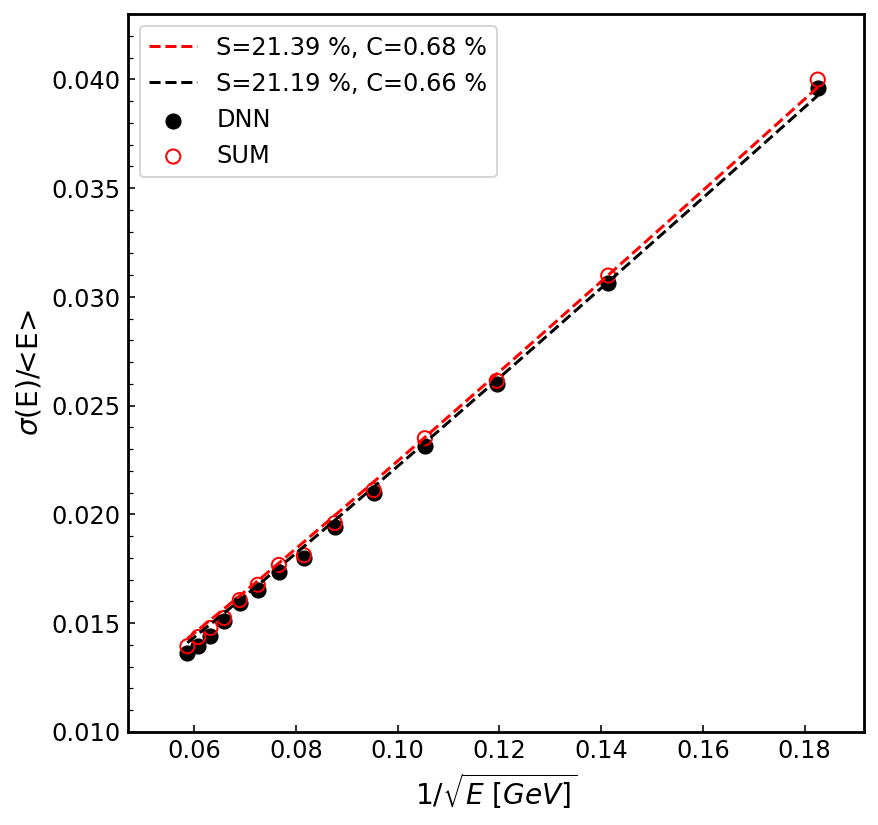

In [42]:
plt.clf()
plt.figure(figsize=(6.6,6.6))
mean_e = 1/np.sqrt([fit_parameters_ml_train[e][0][1]+e for e in fit_parameters_ml_train])
dnn_res_e = np.array([fit_parameters_ml_train[e][0][2] for e in fit_parameters_ml_train])/np.array([fit_parameters_ml_train[e][0][1]+e for e in fit_parameters_ml_train])
dnn_res_hist_data = plt.scatter(mean_e, dnn_res_e,
            marker='o', s=50, edgecolor='black', label='DNN',
            facecolor='black')
dnn_res_results = curve_fit(Pol1PDF, xdata=mean_e**2, ydata=dnn_res_e**2,
         bounds = ((0,0), (1e3,1e3)), p0=(0.2, 0.02))

sum_res_e = np.array([fit_parameters_sum[e][0][2] for e in fit_parameters_sum])/np.array([fit_parameters_sum[e][0][1]+e for e in fit_parameters_sum])
dnn_res_hist_mc = plt.scatter(mean_e, sum_res_e,
            marker='o', s=50, edgecolor='red', label='SUM',
            facecolor='none')
dnn_res_results_mc = curve_fit(Pol1PDF, xdata=mean_e**2, ydata=sum_res_e**2,
         bounds = ((0,0), (1e3,1e3)), p0=(0.2, 0.02))

xarray = np.linspace(mean_e[-1], mean_e[0], 64)
yarray_mc_sum =  np.sqrt(dnn_res_results_mc[0][0]*(xarray**2)+dnn_res_results_mc[0][1])
yarray_data_sum = np.sqrt(dnn_res_results[0][0]*(xarray**2)+dnn_res_results[0][1])

plt.plot(xarray, yarray_mc_sum,
         c='red', linestyle='--',
         label='S={:0.2f} %, C={:0.2f} %'.format(np.sqrt(dnn_res_results_mc[0][0])*100, np.sqrt(dnn_res_results_mc[0][1])*100))
plt.plot(xarray, yarray_data_sum,
         c='black', linestyle='--', 
         label='S={:0.2f} %, C={:0.2f} %'.format(np.sqrt(dnn_res_results[0][0])*100, np.sqrt(dnn_res_results[0][1])*100))

slope_text= plt.text(x=0.0, y=0.035, s='')

plt.ylim(0.01, 0.043)
plt.xlim(mean_e[-1]*0.8, mean_e[0]*1.05)
plt.ylabel('$\sigma$(E)/<E>', size=14)
plt.xlabel('1/$\sqrt{E\ [GeV]}$', size=14)
plt.legend(fontsize=12, loc='upper left')
    
#plt.show()
plt.savefig('resolution.png', dpi=300)